In [ ]:
pip install datasets transformers

In [ ]:
from datasets import load_dataset

ds = load_dataset('/kaggle/input/melanoma-cancer-dataset')

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d bhaveshmittal/melanoma-cancer-dataset
!unzip melanoma-cancer-dataset.zip -d melanoma_data

Dataset URL: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset
License(s): CC0-1.0
melanoma-cancer-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  melanoma-cancer-dataset.zip
replace melanoma_data/test/Benign/6299.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
print(os.listdir("melanoma_data"))

['train', 'test']


In [ ]:
ds = load_dataset('/content/melanoma_data')


Resolving data files:   0%|          | 0/11879 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
from collections import Counter

label_counts = Counter([ex['label'] for ex in ds['train']])
print(label_counts)  # Should show counts for both 'Benign' and 'Malignant'


Counter({0: 6289, 1: 5590})


In [ ]:
labels = ds['train'].features['label']  # Reinitialize the labels


In [ ]:
for i in range(10):  # Check 10 random samples
    ex = ds['train'].shuffle(seed=42).select([i])
    print(f"Raw Label: {ex['label'][0]}, Mapped: {labels.int2str(ex['label'][0])}")


Raw Label: 1, Mapped: Malignant
Raw Label: 0, Mapped: Benign
Raw Label: 1, Mapped: Malignant
Raw Label: 0, Mapped: Benign
Raw Label: 1, Mapped: Malignant
Raw Label: 0, Mapped: Benign
Raw Label: 0, Mapped: Benign
Raw Label: 1, Mapped: Malignant
Raw Label: 1, Mapped: Malignant
Raw Label: 1, Mapped: Malignant


In [ ]:
for ex in ds['train'].shuffle(seed=42).select(range(5)):  # Check a few samples
    print(f"Raw Label: {ex['label']}, Mapped: {labels.int2str(ex['label'])}")


Raw Label: 1, Mapped: Malignant
Raw Label: 0, Mapped: Benign
Raw Label: 1, Mapped: Malignant
Raw Label: 0, Mapped: Benign
Raw Label: 1, Mapped: Malignant


In [ ]:
from datasets import load_dataset

# Load dataset from correct path
ds = load_dataset('/content/melanoma_data')  # Adjust path if needed
print(ds)  # Verify dataset is loaded properly


Resolving data files:   0%|          | 0/11879 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 11879
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
})


In [ ]:
from sklearn.model_selection import train_test_split

# Convert dataset to Pandas DataFrame
df = ds['train'].to_pandas()

# Split into train and validation sets
train_data, val_data = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)


In [ ]:
ex = ds['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'label': 0}

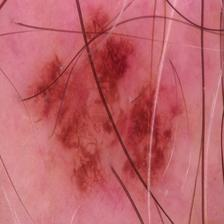

In [ ]:
image = ex['image']
image

In [ ]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['Benign', 'Malignant'], id=None)

In [ ]:
labels.int2str(ex['label'])

'Benign'

Filter:   0%|          | 0/11879 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11879 [00:00<?, ? examples/s]

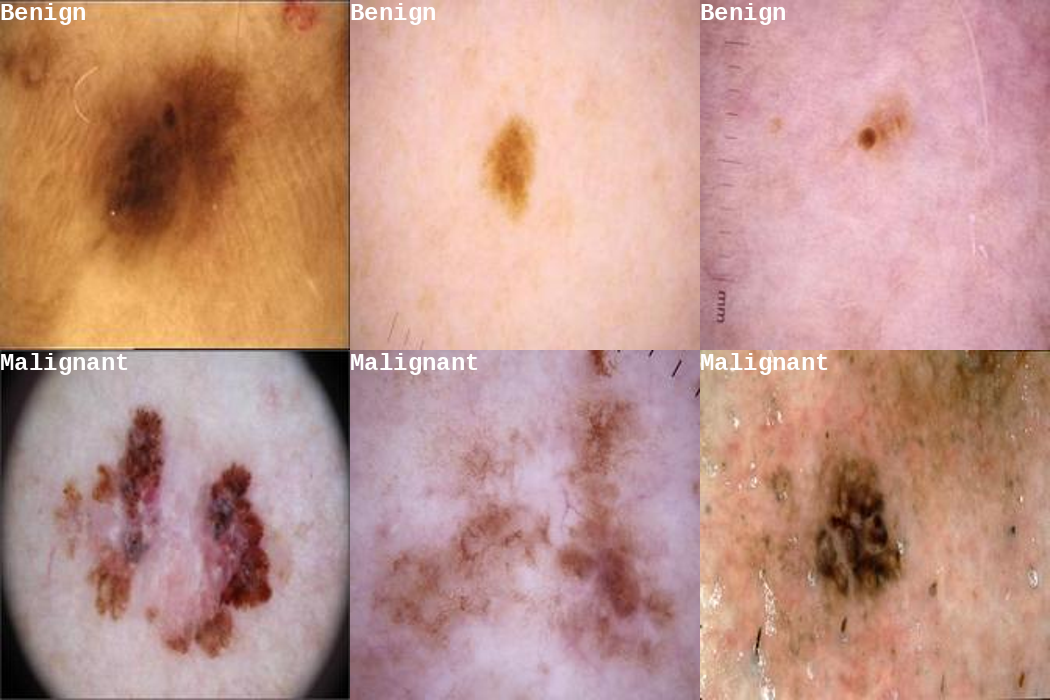

In [ ]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):
    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# Constants
IMG_SIZE = (224, 224)  # ResNet input size
BATCH_SIZE = 32
EPOCHS = 20
DATASET_PATH = "/content/melanoma_data"

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
!pip install torch torchvision matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


In [ ]:
# Training Data Augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation & Test Transform (No Augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
import os
print(os.listdir('/kaggle/input'))


[]


In [ ]:
print(os.listdir('/content/melanoma_data'))


['train', 'test']


In [ ]:
train_dataset_full = datasets.ImageFolder(root="/content/melanoma_data/test", transform=train_transforms)
test_dataset = datasets.ImageFolder(root="/content/melanoma_data/test", transform=test_transforms)


In [ ]:
import os
print(os.listdir('/kaggle/input'))


['melanoma-cancer-dataset']


In [ ]:
import os
print(os.listdir('/kaggle/input/melanoma-cancer-dataset'))


['test', 'train']


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define dataset paths
TRAIN_DIR = "/content/melanoma_data/train"
TEST_DIR = "/content/melanoma_data/test"

# Define Data Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset correctly
train_dataset_full = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transforms)


In [ ]:
from torch.utils.data import random_split

# Split train dataset into Train (80%) and Validation (20%)
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])


In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
import torch.nn as nn
import torchvision.models as models

# Load Pretrained ResNet-18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 2)  # Binary classification: Benign (0) & Malignant (1)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.5MB/s]


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%")


NameError: name 'model' is not defined

In [ ]:
def calculate_accuracy(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation (saves memory & speeds up)
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total * 100  # Return accuracy in percentage


In [ ]:
train_accuracy = calculate_accuracy(model, train_loader, device)
print(f"Train Accuracy: {train_accuracy:.2f}%")


Train Accuracy: 88.31%


In [ ]:
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 82.90%


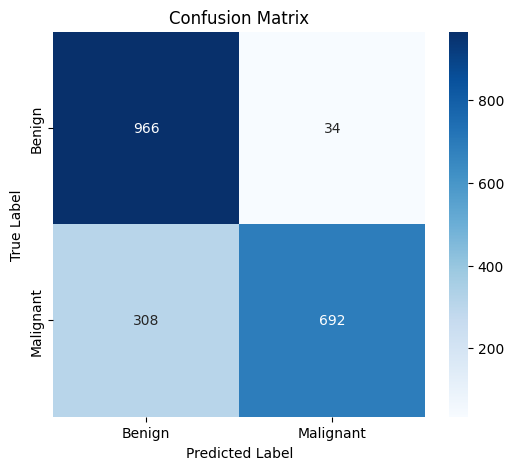

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
y_true = []
y_pred = []

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))


              precision    recall  f1-score   support

      Benign       0.76      0.97      0.85      1000
   Malignant       0.95      0.69      0.80      1000

    accuracy                           0.83      2000
   macro avg       0.86      0.83      0.83      2000
weighted avg       0.86      0.83      0.83      2000



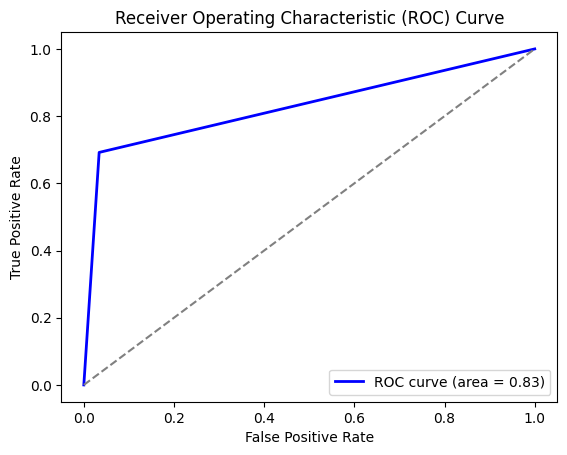

In [ ]:
from sklearn.metrics import roc_curve, auc

y_true_tensor = torch.tensor(y_true)
y_pred_tensor = torch.tensor(y_pred)

fpr, tpr, _ = roc_curve(y_true_tensor, y_pred_tensor)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


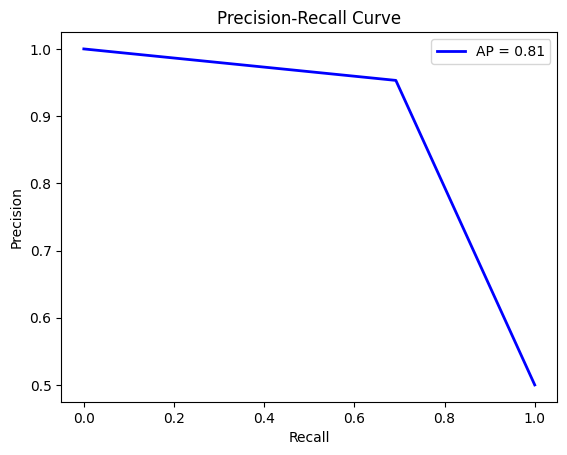

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
avg_precision = average_precision_score(y_true, y_pred)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label=f'AP = {avg_precision:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [ ]:
pip install lime shap torchcam


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
torch.save(model.state_dict(), "model.pth")  # Saves model in current directory


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

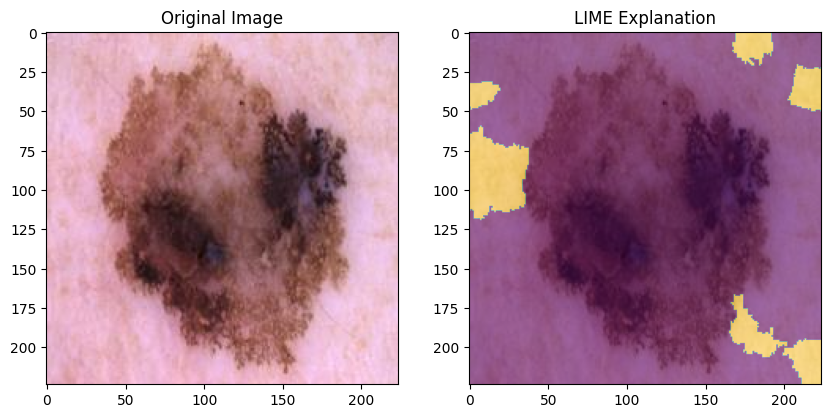

In [ ]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import lime
from lime import lime_image
from skimage.segmentation import slic
import matplotlib.pyplot as plt

# Load ResNet-18 model
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # Assuming 2 classes (melanoma & non-melanoma)
model.load_state_dict(torch.load("model.pth", map_location=torch.device("cpu"), weights_only=True))
  # Load trained model
model.eval()  # Set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load an image for explanation
img_path = "/kaggle/input/melanoma-cancer-dataset/train/Malignant/101.jpg"  # Change this path
image = Image.open(img_path).convert("RGB")  # Convert grayscale images to RGB
image_tensor = transform(image).unsqueeze(0).to(device)  # Convert to tensor & add batch dimension

# Function for LIME to make predictions
def batch_predict(images):
    """
    Function to preprocess LIME images and get model predictions.
    """
    model.eval()
    tensor_imgs = torch.stack([transform(Image.fromarray(img)) for img in images]).to(device)
    outputs = model(tensor_imgs)
    probs = torch.nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    return probs

# Create LIME Explainer
explainer = lime_image.LimeImageExplainer()

# Explain the instance
explanation = explainer.explain_instance(
    np.array(image),  # Convert PIL image to numpy array
    batch_predict,  # Prediction function
    top_labels=2,  # Top classes to explain
    hide_color=0,
    num_samples=1000  # Number of perturbations
)

# Get explanation mask
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Plot Explanation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(temp)
plt.imshow(mask, alpha=0.5)
plt.title("LIME Explanation")

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetModified(nn.Module):
    def __init__(self):
        super(ResNetModified, self).__init__()
        self.model = models.resnet18(pretrained=True)

        # Replace all in-place ReLU with out-of-place ReLU safely
        for module in self.model.modules():
            if isinstance(module, nn.ReLU):
                module.inplace = False  # Fix the in-place operation

    def forward(self, x):
        return self.model(x)

# Initialize the modified model
model = ResNetModified()
model.eval()  # Set to evaluation mode


ResNetModified(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
import torch.nn.functional as F

class ModifiedResNet(torch.nn.Module):
    def __init__(self, base_model):
        super(ModifiedResNet, self).__init__()
        self.model = base_model
        self.model.relu = torch.nn.ReLU(inplace=False)  # Change inplace to False

    def forward(self, x):
        return self.model(x)


In [ ]:
class ModifiedResNet(torch.nn.Module):
    def __init__(self, base_model):
        super(ModifiedResNet, self).__init__()
        self.model = base_model

    def forward(self, x):
        x = self.model(x)
        return x.clone()  # Clone to avoid in-place modification issues


In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    sample_image = torch.randn(1, 3, 224, 224).to(device)  # Replace with an actual image
    output = model(sample_image)
    print(output)


tensor([[ 6.7842e-01,  2.4293e+00,  2.4530e+00,  2.5981e+00,  3.9741e+00,
          3.3260e+00,  3.6118e+00,  5.0172e-01, -5.2627e-01, -5.4114e-01,
         -4.7145e-01,  1.3401e+00,  4.1411e-01,  1.7006e+00,  1.5859e+00,
          1.0594e+00, -5.7629e-01, -1.6491e-01,  1.6511e+00,  4.1270e-01,
          3.0462e-01, -2.8373e-01,  1.1965e+00,  7.0644e-01, -8.0258e-02,
          6.9494e-01,  1.1679e+00,  1.1504e+00,  6.3249e-01,  7.5009e-01,
          1.4846e+00,  9.1118e-01, -3.3213e-01,  2.2302e+00,  2.9623e+00,
          1.0242e+00,  4.0516e-01,  6.9195e-01,  6.4188e-01,  1.9340e+00,
          1.9709e+00,  1.0467e+00,  1.3913e+00,  5.3996e-01,  1.7908e+00,
          5.6316e-01,  2.1631e+00, -1.3428e+00,  1.9650e+00,  8.1907e-01,
          1.9315e+00, -1.8537e+00,  1.2533e+00,  9.9443e-01, -2.5561e-01,
          1.6049e+00, -7.6010e-01,  5.9907e-01,  2.0679e+00,  5.4987e-01,
          1.7331e+00, -2.0319e-02,  1.0487e-02, -1.0717e+00,  2.5557e-01,
          4.0668e+00,  2.5900e-01,  7.

In [ ]:
!pip install shap torchvision torch numpy matplotlib


In [ ]:
import torch
import shap
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image


In [ ]:
# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet-18 (or your trained model)
model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Load a sample melanoma image
image_path = "/kaggle/input/melanoma-cancer-dataset/train/Benign/1009.jpg"  # Replace with actual path
image = Image.open(image_path).convert("RGB")

# Define transformations for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Apply transformation and move to device
image_tensor = transform(image).unsqueeze(0).to(device)


In [ ]:
# Install dependencies
!pip install shap torchvision torch numpy matplotlib

# Import Libraries
import torch
import shap
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image

# Load Pretrained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True).to(device)
model.eval()

# Load & Preprocess Image
image_path = "/kaggle/input/melanoma-cancer-dataset/train/Benign/1009.jpg"  # Replace with your actual image path
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image_tensor = transform(image).unsqueeze(0).to(device)

# Define a function for model prediction
def model_forward(x):
    with torch.no_grad():
        return model(x)

# Convert tensor to numpy for SHAP visualization
def tensor_to_numpy(tensor):
    return tensor.squeeze().permute(1, 2, 0).cpu().numpy()

# Apply SHAP Using GradientExplainer
background = torch.cat([image_tensor] * 50, dim=0)  # Create background dataset
explainer = shap.GradientExplainer(model_forward, background)
shap_values = explainer.shap_values(image_tensor)

# Convert SHAP values to numpy for visualization
shap_values_numpy = np.array(shap_values[0])  # Extract SHAP for first output class

# Plot SHAP Explanation
plt.figure(figsize=(8, 8))
shap.image_plot([shap_values_numpy], [tensor_to_numpy(image_tensor)])
plt.show()


In [ ]:
import torch.nn.functional as F

class ModifiedResNet(torch.nn.Module):
    def __init__(self, base_model):
        super(ModifiedResNet, self).__init__()
        self.model = base_model
        self.model.relu = torch.nn.ReLU(inplace=False)  # Change inplace to False

    def forward(self, x):
        return self.model(x)


In [ ]:
# Install dependencies
!pip install shap torchvision torch numpy matplotlib

# Import Libraries
import torch
import shap
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image

# Load Pretrained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True).to(device)
model.eval()

# Load & Preprocess Image
image_path = "melanoma_sample.jpg"  # Replace with your actual image path
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image_tensor = transform(image).unsqueeze(0).to(device)

# Define a function for model prediction
def model_forward(x):
    return model(x)

# Create a background dataset using random noise (better for SHAP)
background = torch.randn((10, 3, 224, 224)).to(device)  # 10 random samples

# Apply SHAP Using DeepExplainer
explainer = shap.DeepExplainer(model_forward, background)
shap_values = explainer.shap_values(image_tensor)

# Convert SHAP values to numpy for visualization
shap_values_numpy = np.array(shap_values[0])  # Extract SHAP values

# Convert tensor image to NumPy for SHAP visualization
def tensor_to_numpy(tensor):
    return tensor.squeeze().permute(1, 2, 0).cpu().numpy()

# Plot SHAP Explanation
plt.figure(figsize=(8, 8))
shap.image_plot([shap_values_numpy], [tensor_to_numpy(image_tensor)])
plt.show()


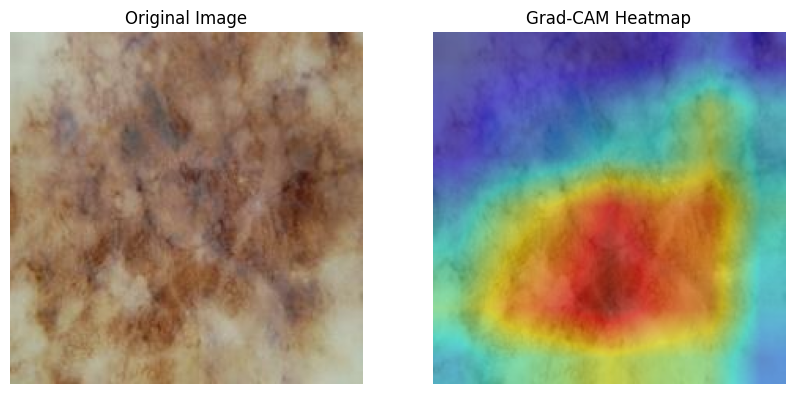

In [ ]:
import torch
import torchvision.models as models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set to evaluation mode

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Grad-CAM Hook to capture gradients
gradients = None
activations = None

def save_gradient(grad):
    global gradients
    gradients = grad

# Register hook to capture the last convolutional layer (ResNet18: layer4)
def forward_hook(module, input, output):
    global activations
    activations = output
    output.register_hook(save_gradient)

# Attach hooks to the last conv layer (layer4 in ResNet-18)
target_layer = model.layer4
hook = target_layer.register_forward_hook(forward_hook)

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
image_path = "/kaggle/input/melanoma-cancer-dataset/train/Malignant/1024.jpg"  # Replace with your image path
image = Image.open(image_path)
img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Forward pass
output = model(img_tensor)
pred_class = output.argmax(dim=1)  # Get predicted class

# Backward pass to get gradients
model.zero_grad()
output[:, pred_class].backward()

# Compute Grad-CAM heatmap
weights = gradients.mean(dim=[2, 3], keepdim=True)  # Global average pooling
gradcam = torch.sum(weights * activations, dim=1).squeeze(0)  # Weighted sum

# Normalize heatmap
gradcam = torch.relu(gradcam).cpu().detach().numpy()
gradcam = cv2.resize(gradcam, (224, 224))  # Resize to match input image
gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())  # Normalize

# Convert image to numpy for overlay
image_np = np.array(image.resize((224, 224))) / 255.0

# Overlay Grad-CAM heatmap on image
heatmap = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
overlay = (0.5 * heatmap / 255.0) + (0.5 * image_np)  # Blend images

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_np)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(overlay)
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis("off")

plt.show()

# Remove hook after execution
hook.remove()


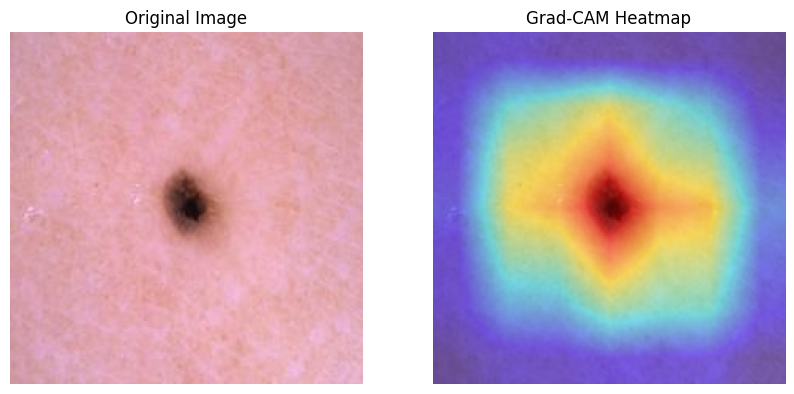

In [ ]:
import torch
import torchvision.models as models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set to evaluation mode

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Grad-CAM Hook to capture gradients
gradients = None
activations = None

def save_gradient(grad):
    global gradients
    gradients = grad

# Register hook to capture the last convolutional layer (ResNet18: layer4)
def forward_hook(module, input, output):
    global activations
    activations = output
    output.register_hook(save_gradient)

# Attach hooks to the last conv layer (layer4 in ResNet-18)
target_layer = model.layer4
hook = target_layer.register_forward_hook(forward_hook)

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
image_path = "/kaggle/input/melanoma-cancer-dataset/train/Benign/1009.jpg"  # Replace with your image path
image = Image.open(image_path)
img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Forward pass
output = model(img_tensor)
pred_class = output.argmax(dim=1)  # Get predicted class

# Backward pass to get gradients
model.zero_grad()
output[:, pred_class].backward()

# Compute Grad-CAM heatmap
weights = gradients.mean(dim=[2, 3], keepdim=True)  # Global average pooling
gradcam = torch.sum(weights * activations, dim=1).squeeze(0)  # Weighted sum

# Normalize heatmap
gradcam = torch.relu(gradcam).cpu().detach().numpy()
gradcam = cv2.resize(gradcam, (224, 224))  # Resize to match input image
gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())  # Normalize

# Convert image to numpy for overlay
image_np = np.array(image.resize((224, 224))) / 255.0

# Overlay Grad-CAM heatmap on image
heatmap = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
overlay = (0.5 * heatmap / 255.0) + (0.5 * image_np)  # Blend images

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_np)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(overlay)
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis("off")

plt.show()

# Remove hook after execution
hook.remove()
